In [1]:
# pip install pyfolio
# pip install nbformat

In [2]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

c:\Users\josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


| Variable                  | Description                     |
|---------------------------|---------------------------------|
| Date                     | Date of the data points        |
| PX_LAST                   | Last Price                      |
| PX_BID                    | Bid Price                       |
| LAST_PRICE                | Last Trade/Last Price           |
| PX_ASK                    | Ask Price                       |
| PX_MID                    | Mid Price                       |
| CHG_PCT_1D                | Price Change 1 Day Percent      |
| CUR_MKT_CAP               | Current Market Cap              |
| PX_CLOSE_1D               | Closing Price 1 Day Ago         |

In [10]:
equity = pd.read_csv('./Cleaned_Data/SPX.csv')
highyield = pd.read_csv('./Cleaned_Data/highyield.csv')
safebond = pd.read_csv('./Cleaned_Data/safebond.csv')

equity['Dates'] = pd.to_datetime(equity['Dates'])
highyield['Dates'] = pd.to_datetime(highyield['Dates'])
safebond['Dates'] = pd.to_datetime(safebond['Dates'])

### No Rebalancing - Buy and Hold

Synthetic Portfolio Analysis using index returns

In [4]:
# Define portfolio allocations
allocations_A = {'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50}
allocations_B = {'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50}
allocations_C = {'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40}
allocations_D = {'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45}

# Create a DataFrame using the allocation variables
allocations_df = pd.DataFrame({
    'Asset': ['Equities', 'HighYieldBonds', 'InvGradeBonds'],
    'Index': ['SPX', 'Bloomberg HighYield', 'Bloomberg Agg'],
    'Allocation_A': [allocations_A['Equities'], allocations_A['HighYieldBonds'], allocations_A['InvGradeBonds']],
    'Allocation_B': [allocations_B['Equities'], allocations_B['HighYieldBonds'], allocations_B['InvGradeBonds']],
    'Allocation_C': [allocations_C['Equities'], allocations_C['HighYieldBonds'], allocations_C['InvGradeBonds']],
    'Allocation_D': [allocations_D['Equities'], allocations_D['HighYieldBonds'], allocations_D['InvGradeBonds']]
})
allocations_df

,Asset,Index,Allocation_A,Allocation_B,Allocation_C,Allocation_D
0,Equities,SPX,0.5,0.4,0.5,0.45
1,HighYieldBonds,Bloomberg HighYield,0.0,0.1,0.1,0.10
2,InvGradeBonds,Bloomberg Agg,0.5,0.5,0.4,0.45


In [5]:
# start_date = '1983-07-29' 
# end_date = '2024-06-25'

start_date = '1983-08-01'
end_date = '2024-06-25'

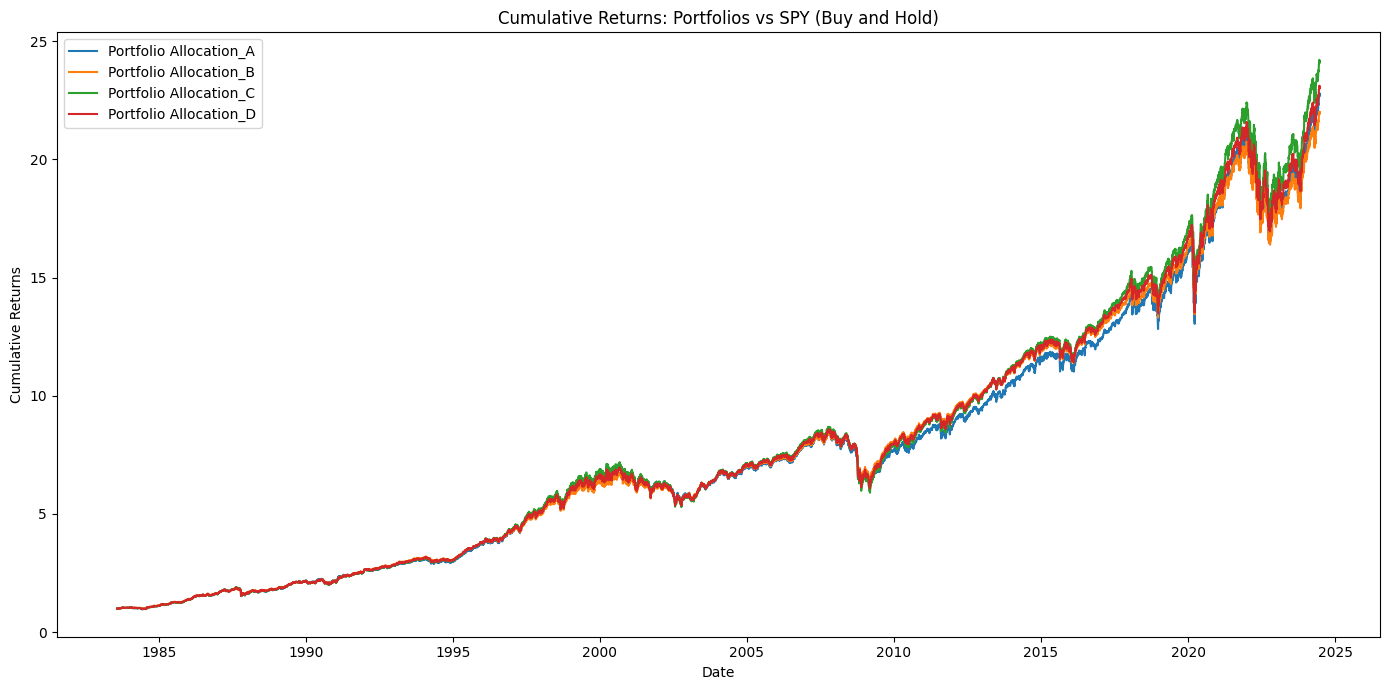

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function with SPY as benchmark for buy-and-hold strategy
def backtest_portfolios_buy_and_hold(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond):
    cumulative_product_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'Index' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate cumulative returns for each asset
        agg_cum_returns = (1 + agg_backtest['DailyReturn']).cumprod()
        jnk_cum_returns = (1 + jnk_backtest['DailyReturn']).cumprod()
        spy_cum_returns = (1 + spy_backtest['DailyReturn']).cumprod()

        # Calculate portfolio cumulative returns based on initial allocation
        portfolio_cumulative_product = (
            allocations['Equities'] * spy_cum_returns +
            allocations['HighYieldBonds'] * jnk_cum_returns +
            allocations['InvGradeBonds'] * agg_cum_returns
        )
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    #plt.plot(combined_index, (1 + spy_backtest['DailyReturn']).cumprod(), label='SPY (Benchmark)', color='green')
    plt.title('Cumulative Returns: Portfolios vs SPY (Buy and Hold)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict

# Call the function and print the results
buy_hold_dict = backtest_portfolios_buy_and_hold(allocations_df, start_date, end_date)

In [7]:
def calculate_performance_metrics(cumulative_product):
    end_return = cumulative_product.iloc[-1] - 1
    daily_returns = cumulative_product.pct_change().dropna()
    annualized_return = np.mean(daily_returns) * 252
    annualized_volatility = np.std(daily_returns) * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    running_max = cumulative_product.cummax()
    drawdown = (cumulative_product - running_max) / running_max
    max_drawdown = drawdown.min()
    max_drawdown_date = drawdown.idxmin().strftime("%Y-%m-%d")
    
    return end_return, annualized_return, annualized_volatility, sharpe_ratio, max_drawdown, max_drawdown_date

In [13]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in buy_hold_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Allocation_A,21.747985,0.055979,0.080388,0.696358,-0.290961,2009-03-09
Allocation_B,20.97602,0.054374,0.06661,0.816304,-0.258946,2009-03-09
Allocation_C,23.155385,0.056931,0.079614,0.715088,-0.321133,2009-03-09
Allocation_D,22.065702,0.055646,0.073057,0.761675,-0.290453,2009-03-09


### Rebalance Daily

In [14]:
# this basically daily rebalancing, fixed allocation

def backtest_portfolios_daily(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Calculate portfolio daily returns
        portfolio_daily_returns = (
            allocations['Equities'] * spy_backtest['DailyReturn'] +
            allocations['HighYieldBonds'] * jnk_backtest['DailyReturn'] +
            allocations['InvGradeBonds'] * agg_backtest['DailyReturn']
        )

        # Compute cumulative returns
        portfolio_cumulative_product = (1 + portfolio_daily_returns).cumprod()
        cumulative_product_dict[allocation_name] = portfolio_cumulative_product
        
        portfolio_daily_returns_dict[allocation_name] = portfolio_daily_returns
        

    # Plot all cumulative returns on the same plot
    plt.figure(figsize=(14, 7))
    for allocation_name, cumulative_product in cumulative_product_dict.items():
        plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Growth')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return cumulative_product_dict

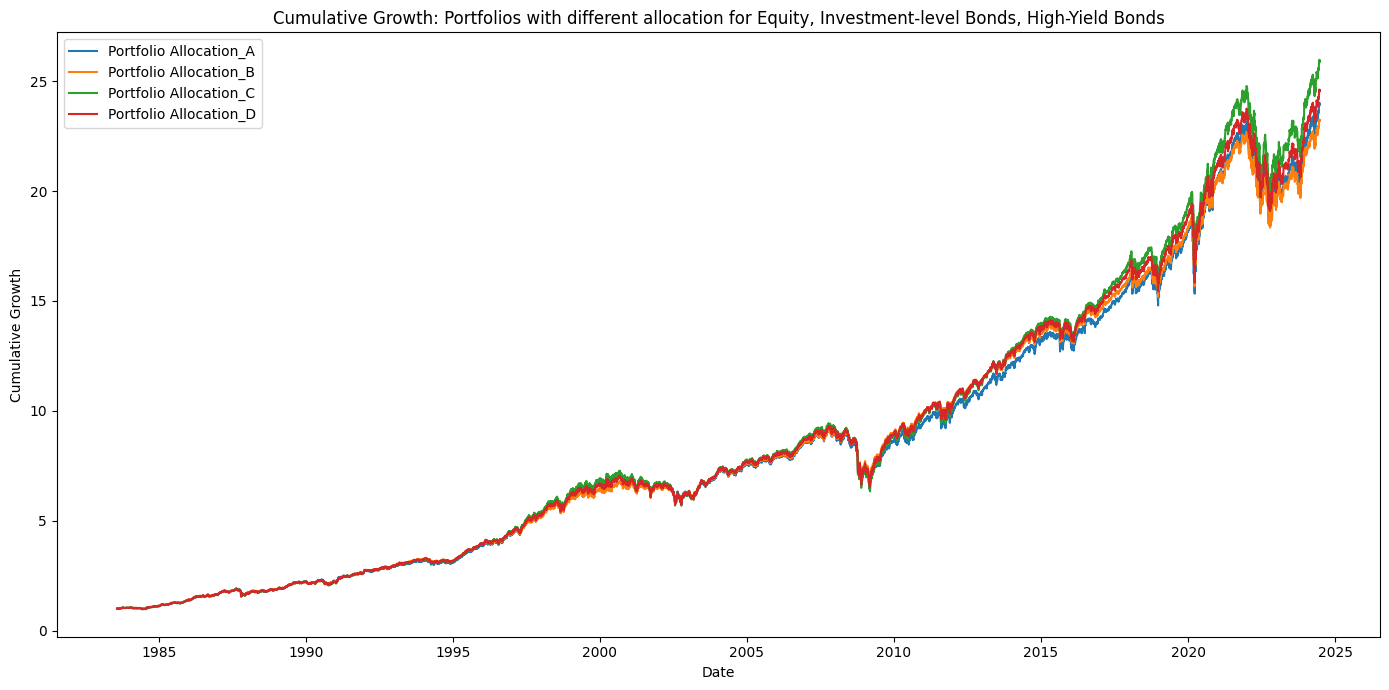

In [15]:
daily_rebalancing_dict = backtest_portfolios_daily(allocations_df, start_date, end_date)

In [16]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in daily_rebalancing_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

,Total Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Date
Allocation_A,22.965764,0.056554,0.076532,0.73896,-0.299707,2009-03-09
Allocation_B,22.220781,0.055105,0.063592,0.866547,-0.2653,2009-03-09
Allocation_C,24.927154,0.057928,0.077128,0.751065,-0.327925,2009-03-09
Allocation_D,23.581443,0.056517,0.070252,0.804487,-0.29682,2009-03-09


### Rebalance With Customized Frequency

In [ ]:
# # Monthly, Yearly

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Initialize portfolio values and weights
#         portfolio_value = 1.0
#         weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
#         # portfolio_values = []
#         portfolio_values = [portfolio_value]
#         portfolio_daily_returns = []

#         # Rebalance dates based on the specified frequency
#         rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

#         for date in combined_index:
#             if date in rebalance_dates:
#                 # Rebalance the portfolio
#                 current_values = np.array([
#                     weights[0] * spy_backtest.loc[date]['DailyReturn'] + 1,
#                     weights[1] * jnk_backtest.loc[date]['DailyReturn'] + 1,
#                     weights[2] * agg_backtest.loc[date]['DailyReturn'] + 1
#                 ])
#                 # portfolio_value = portfolio_value * current_values.sum()
#                 portfolio_value *= current_values.sum() / current_values.dot(weights)
#                 weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
#             else:
#                 # Calculate portfolio return
#                 daily_returns = np.array([
#                     spy_backtest.loc[date]['DailyReturn'],
#                     jnk_backtest.loc[date]['DailyReturn'],
#                     agg_backtest.loc[date]['DailyReturn']
#                 ])
#                 portfolio_return = np.dot(weights, daily_returns)
#                 portfolio_value *= (1 + portfolio_return)
            
#             portfolio_values.append(portfolio_value)
#             portfolio_daily_returns.append(portfolio_return)

#         cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=combined_index)
#         portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)
        
#     # Plot all cumulative returns on the same plot
#     plt.figure(figsize=(14, 7))
#     for allocation_name, cumulative_product in cumulative_product_dict.items():
#         plt.plot(cumulative_product.index, cumulative_product, label=f'Portfolio {allocation_name}')
#     plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
#     plt.xlabel('Date')
#     plt.ylabel('Cumulative Growth')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return portfolio_daily_returns_dict #cumulative_product_dict

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Initialize portfolio values and weights
#         portfolio_value = 1.0
#         weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
#         portfolio_values = [portfolio_value]
#         portfolio_daily_returns = []

#         # Rebalance dates based on the specified frequency
#         rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

#         for date in combined_index:
#             if date in rebalance_dates:
#                 # Rebalance the portfolio
#                 current_values = np.array([
#                     weights[0] * (spy_backtest.loc[date]['DailyReturn'] + 1),
#                     weights[1] * (jnk_backtest.loc[date]['DailyReturn'] + 1),
#                     weights[2] * (agg_backtest.loc[date]['DailyReturn'] + 1)
#                 ])
#                 portfolio_value *= current_values.sum() / current_values.dot(weights)
#                 weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
#             else:
#                 # Calculate portfolio return
#                 daily_returns = np.array([
#                     spy_backtest.loc[date]['DailyReturn'],
#                     jnk_backtest.loc[date]['DailyReturn'],
#                     agg_backtest.loc[date]['DailyReturn']
#                 ])
#                 portfolio_return = np.dot(weights, daily_returns)
#                 portfolio_value *= (1 + portfolio_return)

#             portfolio_values.append(portfolio_value)
#             portfolio_daily_returns.append(portfolio_return)

#         cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index))
#         # cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=combined_index)
#         portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)

#     # # Plot all cumulative returns on the same plot
#     # plt.figure(figsize=(14, 7))
#     # for allocation_name, cumulative_product in cumulative_product_dict.items():
#     #     plt.plot(cumulative_product.index, cumulative_product.values, label=f'Portfolio {allocation_name}')
#     # plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
#     # plt.xlabel('Date')
#     # plt.ylabel('Cumulative Growth')
#     # plt.legend()
#     # plt.tight_layout()
#     # plt.show()

#     return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

# # Example usage
# month_rebalancing_dict, cumulative_product_dict, portfolio_values = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='M')  # Monthly rebalancing

In [17]:
# I think this one is the right one but has plotting issue

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
    cumulative_product_dict = {}
    portfolio_daily_returns_dict = {}

    for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
        # Extract the allocation values from allocations_df
        allocations = {
            'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
            'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
            'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
        }

        agg.ffill(inplace=True)
        jnk.ffill(inplace=True)
        spy.ffill(inplace=True)
        # Filter the data for the backtest period
        agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
        jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
        spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

        # Align the indices
        combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
        agg_backtest = agg_backtest.loc[combined_index]
        jnk_backtest = jnk_backtest.loc[combined_index]
        spy_backtest = spy_backtest.loc[combined_index]

        # Initialize portfolio values and weights
        portfolio_value = 1.0
        portfolio_values = [portfolio_value]
        portfolio_daily_returns = []

        # Initialize weights
        weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

        # Rebalance dates based on the specified frequency
        rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

        for date in combined_index:
            if date in rebalance_dates:
                # Rebalance the portfolio
                
                # assume you initialize the portfolio on the first rebalance date
                total_value = (
                    weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
                    weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
                    weights[2] * agg_backtest.loc[date]['LAST_PRICE']
                )
                weights = np.array([
                    allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
                    allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
                    allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
                ])
                weights /= weights.sum()  # Normalize weights to sum to 1

            # Calculate portfolio return
            daily_returns = np.array([
                spy_backtest.loc[date]['DailyReturn'],
                jnk_backtest.loc[date]['DailyReturn'],
                agg_backtest.loc[date]['DailyReturn']
            ])
            portfolio_return = np.dot(weights, daily_returns)
            portfolio_value *= (1 + portfolio_return)

            portfolio_values.append(portfolio_value)
            portfolio_daily_returns.append(portfolio_return)

        cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index))
        portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)


    # # Plot all cumulative returns on the same plot
    # plt.figure(figsize=(14, 7))
    # for allocation_name, cumulative_product in cumulative_product_dict.items():
    #     plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
    # plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
    # plt.xlabel('Date')
    # plt.ylabel('Cumulative Growth')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()


    return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

In [18]:
portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='M')

Here is the issue that the length are differents between portfolio daily return and the cumlative return 

In [19]:
portfolio_daily_returns_dict 

{'Allocation_A': Dates
 1983-08-01   -0.001599
 1983-08-02   -0.000093
 1983-08-03    0.004413
 1983-08-04   -0.006455
 1983-08-05    0.001271
                 ...   
 2024-06-21   -0.000327
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000339
 2024-06-25    0.001255
 Length: 14940, dtype: float64,
 'Allocation_B': Dates
 1983-08-01   -0.001280
 1983-08-02   -0.000074
 1983-08-03    0.003531
 1983-08-04   -0.005164
 1983-08-05    0.001017
                 ...   
 2024-06-21   -0.000193
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000044
 2024-06-25    0.000998
 Length: 14940, dtype: float64,
 'Allocation_C': Dates
 1983-08-01   -0.001599
 1983-08-02   -0.000093
 1983-08-03    0.004413
 1983-08-04   -0.006455
 1983-08-05    0.001271
                 ...   
 2024-06-21   -0.000326
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000339
 2024-06-25    0.001290
 Length: 14940, dtype: float64,
 'Allocation_D': Dates
 1983-08-01   -0.001

In [23]:
import pandas as pd

# Get the series for 'Allocation_A'
allocation_a_series = portfolio_daily_returns_dict.get('Allocation_A')

# Convert the series to a DataFrame
allocation_a_df = allocation_a_series.reset_index()
allocation_a_df.columns = ['Date', 'Allocation_A']
allocation_a_df

,Date,Allocation_A
0,1983-08-01,-0.001599
1,1983-08-02,-0.000093
2,1983-08-03,0.004413
3,1983-08-04,-0.006455
4,1983-08-05,0.001271
...,...,...
14935,2024-06-21,-0.000327
14936,2024-06-22,0.000000
14937,2024-06-23,0.000000
14938,2024-06-24,-0.000339


In [22]:
import pandas as pd

# Get the series for 'Allocation_A'
allocation_a_series = cumulative_product_dict.get('Allocation_A')

# Convert the series to a DataFrame
allocation_a_df = allocation_a_series.reset_index()
allocation_a_df.columns = ['Date', 'Allocation_A']
allocation_a_df

,Date,Allocation_A
0,1983-08-01,1.000000
1,1983-08-01,0.998401
2,1983-08-02,0.998308
3,1983-08-03,1.002714
4,1983-08-04,0.996242
...,...,...
14936,2024-06-21,24.056387
14937,2024-06-22,24.056387
14938,2024-06-23,24.056387
14939,2024-06-24,24.048225


In [ ]:
# # need to check the difference 
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Initialize portfolio values and weights
#         portfolio_value = 1.0
#         portfolio_values = [portfolio_value]
#         portfolio_daily_returns = []

#         # initialize weights
#         weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
        
#         # Rebalance dates based on the specified frequency
#         rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

#         for date in combined_index:
#             if date in rebalance_dates:
#                 # Rebalance the portfolio
#                 weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])
#             else:
#                 # Calculate portfolio return
#                 daily_returns = np.array([
#                     spy_backtest.loc[date]['DailyReturn'],
#                     jnk_backtest.loc[date]['DailyReturn'],
#                     agg_backtest.loc[date]['DailyReturn']
#                 ])
#                 portfolio_return = np.dot(weights, daily_returns)
#                 portfolio_value *= (1 + portfolio_return)

#             portfolio_values.append(portfolio_value)
#             portfolio_daily_returns.append(portfolio_return)

#         cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index))
#         portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)

#     return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

# # # Example usage
# # annual_rebalancing_dict, cumulative_product_dict, portfolio_values = backtest_portfolios(allocations_df, start_date, end_date, rebalance_freq='M')  # Monthly rebalancing

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Initialize portfolio values and weights
#         portfolio_value = 1.0
#         portfolio_values = [portfolio_value]
#         portfolio_daily_returns = []

#         # Initialize weights
#         weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

#         # Rebalance dates based on the specified frequency
#         rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

#         for date in combined_index:
#             if date == pd.to_datetime(backtest_start_date):
#                 # Initialize the portfolio at the start date
#                 total_value = (
#                     weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
#                     weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
#                     weights[2] * agg_backtest.loc[date]['LAST_PRICE']
#                 )
#                 weights = np.array([
#                     allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
#                     allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
#                     allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
#                 ])
#                 weights /= weights.sum()  # Normalize weights to sum to 1

#             if date in rebalance_dates:
#                 # Rebalance the portfolio
#                 total_value = (
#                     weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
#                     weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
#                     weights[2] * agg_backtest.loc[date]['LAST_PRICE']
#                 )
#                 weights = np.array([
#                     allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
#                     allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
#                     allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
#                 ])
#                 weights /= weights.sum()  # Normalize weights to sum to 1

#             # Calculate portfolio return
#             daily_returns = np.array([
#                 spy_backtest.loc[date]['DailyReturn'],
#                 jnk_backtest.loc[date]['DailyReturn'],
#                 agg_backtest.loc[date]['DailyReturn']
#             ])
#             portfolio_return = np.dot(weights, daily_returns)
#             portfolio_value *= (1 + portfolio_return)

#             portfolio_values.append(portfolio_value)
#             portfolio_daily_returns.append(portfolio_return)

#         cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index))
#         portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)

#     return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, rebalance_freq='M'):
#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         agg.ffill(inplace=True)
#         jnk.ffill(inplace=True)
#         spy.ffill(inplace=True)
#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Initialize portfolio values and weights
#         portfolio_value = 1.0
#         portfolio_values = [portfolio_value]
#         portfolio_daily_returns = []

#         # Initialize weights
#         weights = np.array([allocations['Equities'], allocations['HighYieldBonds'], allocations['InvGradeBonds']])

#         # Rebalance dates based on the specified frequency
#         rebalance_dates = pd.date_range(start=backtest_start_date, end=backtest_end_date, freq=rebalance_freq)

#         for date in combined_index:
#             if date in rebalance_dates:
#                 # Rebalance the portfolio
                
#                 # assume you initialize the portfolio on the first rebalance date
#                 total_value = (
#                     weights[0] * spy_backtest.loc[date]['LAST_PRICE'] +
#                     weights[1] * jnk_backtest.loc[date]['LAST_PRICE'] +
#                     weights[2] * agg_backtest.loc[date]['LAST_PRICE']
#                 )
#                 weights = np.array([
#                     allocations['Equities'] * total_value / spy_backtest.loc[date]['LAST_PRICE'],
#                     allocations['HighYieldBonds'] * total_value / jnk_backtest.loc[date]['LAST_PRICE'],
#                     allocations['InvGradeBonds'] * total_value / agg_backtest.loc[date]['LAST_PRICE']
#                 ])
#                 weights /= weights.sum()  # Normalize weights to sum to 1

#             # Calculate portfolio return
#             daily_returns = np.array([
#                 spy_backtest.loc[date]['DailyReturn'],
#                 jnk_backtest.loc[date]['DailyReturn'],
#                 agg_backtest.loc[date]['DailyReturn']
#             ])
#             portfolio_return = np.dot(weights, daily_returns)
#             portfolio_value *= (1 + portfolio_return)

#             portfolio_values.append(portfolio_value)
#             portfolio_daily_returns.append(portfolio_return)

#         cumulative_product_dict[allocation_name] = pd.Series(portfolio_values, index=[pd.to_datetime(backtest_start_date)] + list(combined_index))
#         portfolio_daily_returns_dict[allocation_name] = pd.Series(portfolio_daily_returns, index=combined_index)


#     # # Plot all cumulative returns on the same plot
#     # plt.figure(figsize=(14, 7))
#     # for allocation_name, cumulative_product in cumulative_product_dict.items():
#     #     plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
#     # plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
#     # plt.xlabel('Date')
#     # plt.ylabel('Cumulative Growth')
#     # plt.legend()
#     # plt.tight_layout()
#     # plt.show()


#     return portfolio_daily_returns_dict, cumulative_product_dict, portfolio_values


In [24]:
# Rebalance dates based on the specified frequency
rebalance_dates = pd.date_range(start=start_date , end=end_date, freq='M')

In [25]:
rebalance_dates

DatetimeIndex(['1983-08-31', '1983-09-30', '1983-10-31', '1983-11-30',
               '1983-12-31', '1984-01-31', '1984-02-29', '1984-03-31',
               '1984-04-30', '1984-05-31',
               ...
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31'],
              dtype='datetime64[ns]', length=490, freq='ME')

In [ ]:
# Assuming 'LAST_PRICE' is the close price
equity_close_prices = equity[['Dates', 'LAST_PRICE']]

# Check if the dates in equity_close_prices are in rebalance_dates
equity_close_prices['IsRebalanceDate'] = equity_close_prices['Dates'].isin(rebalance_dates)

# Filter the DataFrame to get only the rows where IsRebalanceDate is True
rebalance_date_prices = equity_close_prices[equity_close_prices['IsRebalanceDate']]

# Display the filtered DataFrame
rebalance_date_prices[['Dates', 'LAST_PRICE']]

,Dates,LAST_PRICE
2,1983-07-31,NaN
33,1983-08-31,164.40
63,1983-09-30,166.07
94,1983-10-31,163.55
124,1983-11-30,166.40
...,...,...
14796,2024-01-31,4845.65
14825,2024-02-29,5096.27
14856,2024-03-31,NaN
14886,2024-04-30,5035.69


In [ ]:
# Calculate the length of the array
length_of_portfolio_values = len(portfolio_values)

# Calculate the number of NaN values
num_nan_values = np.isnan(portfolio_values).sum()

print(f"Length of portfolio_values: {length_of_portfolio_values}")
print(f"Number of NaN values in portfolio_values: {num_nan_values}")

Length of portfolio_values: 14944
Number of NaN values in portfolio_values: 14943


In [ ]:
portfolio_values

[1.0,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
annual_rebalancing_dict

{'Allocation_A': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001599
 1983-08-02   -0.000093
                 ...   
 2024-06-21   -0.000695
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.001153
 2024-06-25    0.002055
 Length: 14943, dtype: float64,
 'Allocation_B': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001280
 1983-08-02   -0.000074
                 ...   
 2024-06-21   -0.000512
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000750
 2024-06-25    0.001687
 Length: 14943, dtype: float64,
 'Allocation_C': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001599
 1983-08-02   -0.000093
                 ...   
 2024-06-21   -0.000686
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.001132
 2024-06-25    0.002063
 Length: 14943, dtype: float64,
 'Allocation_D': Dates
 1983-07-29         

In [ ]:
cumulative_product_dict

{'Allocation_A': 1983-07-29    1.0
 1983-07-29    NaN
 1983-07-30    NaN
 1983-07-31    NaN
 1983-08-01    NaN
              ... 
 2024-06-21    NaN
 2024-06-22    NaN
 2024-06-23    NaN
 2024-06-24    NaN
 2024-06-25    NaN
 Length: 14944, dtype: float64,
 'Allocation_B': 1983-07-29    1.0
 1983-07-29    NaN
 1983-07-30    NaN
 1983-07-31    NaN
 1983-08-01    NaN
              ... 
 2024-06-21    NaN
 2024-06-22    NaN
 2024-06-23    NaN
 2024-06-24    NaN
 2024-06-25    NaN
 Length: 14944, dtype: float64,
 'Allocation_C': 1983-07-29    1.0
 1983-07-29    NaN
 1983-07-30    NaN
 1983-07-31    NaN
 1983-08-01    NaN
              ... 
 2024-06-21    NaN
 2024-06-22    NaN
 2024-06-23    NaN
 2024-06-24    NaN
 2024-06-25    NaN
 Length: 14944, dtype: float64,
 'Allocation_D': 1983-07-29    1.0
 1983-07-29    NaN
 1983-07-30    NaN
 1983-07-31    NaN
 1983-08-01    NaN
              ... 
 2024-06-21    NaN
 2024-06-22    NaN
 2024-06-23    NaN
 2024-06-24    NaN
 2024-06-25    NaN
 Len

In [ ]:
# # Semimonthly

# def backtest_portfolios(allocations_df, backtest_start_date, backtest_end_date, spy=equity, jnk=highyield, agg=safebond, frequency='6M'):
#     import pandas as pd
#     import numpy as np
#     import matplotlib.pyplot as plt

#     cumulative_product_dict = {}
#     portfolio_daily_returns_dict = {}

#     for allocation_name in allocations_df.columns[2:]:  # Skip 'Asset' and 'ETFs' columns
#         # Extract the allocation values from allocations_df
#         allocations = {
#             'Equities': allocations_df.loc[allocations_df['Asset'] == 'Equities', allocation_name].values[0],
#             'HighYieldBonds': allocations_df.loc[allocations_df['Asset'] == 'HighYieldBonds', allocation_name].values[0],
#             'InvGradeBonds': allocations_df.loc[allocations_df['Asset'] == 'InvGradeBonds', allocation_name].values[0]
#         }

#         # Filter the data for the backtest period
#         agg_backtest = agg[(agg['Dates'] >= backtest_start_date) & (agg['Dates'] <= backtest_end_date)].set_index('Dates')
#         jnk_backtest = jnk[(jnk['Dates'] >= backtest_start_date) & (jnk['Dates'] <= backtest_end_date)].set_index('Dates')
#         spy_backtest = spy[(spy['Dates'] >= backtest_start_date) & (spy['Dates'] <= backtest_end_date)].set_index('Dates')

#         # Align the indices
#         combined_index = agg_backtest.index.intersection(jnk_backtest.index).intersection(spy_backtest.index)
#         agg_backtest = agg_backtest.loc[combined_index]
#         jnk_backtest = jnk_backtest.loc[combined_index]
#         spy_backtest = spy_backtest.loc[combined_index]

#         # Resample to the desired frequency
#         agg_backtest = agg_backtest.resample(frequency).last()
#         jnk_backtest = jnk_backtest.resample(frequency).last()
#         spy_backtest = spy_backtest.resample(frequency).last()

#         # Calculate portfolio returns at each rebalancing period
#         portfolio_cumulative_product = pd.Series(index=combined_index)
#         portfolio_cumulative_product.iloc[0] = 1  # Start with an initial value of 1

#         for i in range(1, len(combined_index)):
#             # Calculate returns for the period
#             period_returns = (
#                 allocations['Equities'] * spy_backtest['DailyReturn'].iloc[i] +
#                 allocations['HighYieldBonds'] * jnk_backtest['DailyReturn'].iloc[i] +
#                 allocations['InvGradeBonds'] * agg_backtest['DailyReturn'].iloc[i]
#             )
#             portfolio_cumulative_product.iloc[i] = portfolio_cumulative_product.iloc[i-1] * (1 + period_returns)

#         cumulative_product_dict[allocation_name] = portfolio_cumulative_product
#         portfolio_daily_returns_dict[allocation_name] = portfolio_cumulative_product.pct_change().dropna()

#     # Plot all cumulative returns on the same plot
#     plt.figure(figsize=(14, 7))
#     for allocation_name, cumulative_product in cumulative_product_dict.items():
#         plt.plot(combined_index, cumulative_product, label=f'Portfolio {allocation_name}')
#     plt.title('Cumulative Growth: Portfolios with different allocation for Equity, Investment-level Bonds, High-Yield Bonds')
#     plt.xlabel('Date')
#     plt.ylabel('Cumulative Growth')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return portfolio_daily_returns_dict

In [ ]:
annual_rebalancing_dict

{'Allocation_A': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001599
 1983-08-02   -0.000093
                 ...   
 2024-06-21   -0.000695
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.001153
 2024-06-25    0.002055
 Length: 14943, dtype: float64,
 'Allocation_B': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001280
 1983-08-02   -0.000074
                 ...   
 2024-06-21   -0.000512
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.000750
 2024-06-25    0.001687
 Length: 14943, dtype: float64,
 'Allocation_C': Dates
 1983-07-29         NaN
 1983-07-30    0.000000
 1983-07-31    0.000000
 1983-08-01   -0.001599
 1983-08-02   -0.000093
                 ...   
 2024-06-21   -0.000686
 2024-06-22    0.000000
 2024-06-23    0.000000
 2024-06-24   -0.001132
 2024-06-25    0.002063
 Length: 14943, dtype: float64,
 'Allocation_D': Dates
 1983-07-29         

In [ ]:
# Iterate over each allocation's returns and calculate performance metrics
performance_metrics = {}
for allocation_name, returns in annual_rebalancing_dict.items():
    performance_metrics[allocation_name] = calculate_performance_metrics(returns)

# Convert the performance metrics dictionary to a DataFrame
performance_df = pd.DataFrame(performance_metrics, index=['Total Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Max Drawdown Date']).T

# Print the DataFrame
performance_df

##### Baseline Strategy
'Equities': 0.50, 'HighYieldBonds': 0.00, 'InvGradeBonds': 0.50

##### JS Strategy
'Equities': 0.40, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.50

##### JB Strategy
'Equities': 0.50, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.40

##### JE Strategy
'Equities': 0.45, 'HighYieldBonds': 0.10, 'InvGradeBonds': 0.45